In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    
from utils import *

sys.path.append('../')
from models.Modules import Encoder, Decoder, VAE, VariationalDisentangleModule,\
OffsetRegressorA, OffsetRegressorB, OffsetRegressor

from arap_core.arap_torch import ARAP


c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


In [2]:
img_path = '../datasets/CelebA/images224x224/{}.jpg'
parsing_path = '../datasets/CelebA/parsing_masks/{}.npy'
shape_path = '../datasets/CelebA/raw_bfm_shape/{}.npy'
albedo_path = '../datasets/CelebA/raw_bfm_color/{}.npy'
coeff_path = '../datasets/CelebA/bfm_fitting_coeffs/{}.mat'
landmark_path = '../datasets/CelebA/68_landmarks224x224/{}.npy'

img_indices = []
for fname in os.listdir('../datasets/CelebA/parsing_masks/'):
    if fname.endswith('.npy'):
         img_indices.append(fname[:-4])

print(len(img_indices))


10


In [3]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
parts_vertices = []
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
        parts_vertices.append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
        parts_vertices.append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
        parts_vertices.append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
        parts_vertices.append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
        parts_vertices.append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

print('All parts n_vert: ', len(parts_vertices))


#########################
## Latent dimensions
latent_dims = {}
latent_dims['S_overall'] = 30
latent_dims['S_eyebrows'] = 10
latent_dims['S_eyes'] = 10
latent_dims['S_llip'] = 10
latent_dims['S_ulip'] = 10
latent_dims['S_nose'] = 10


latent_coeff_from_to = {} # later we use the pre-generated indices to merge the part latents 
for s in ['S', 'T']:
    _from_ = 0
    for key in latent_dims:
        if key[0] == s:
            latent_coeff_from_to[key] = (_from_, _from_ + latent_dims[key])
            _from_ += latent_dims[key]
        else:
            continue
print(latent_coeff_from_to)




{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576
All parts n_vert:  3626
{'S_overall': (0, 30), 'S_eyebrows': (30, 40), 'S_eyes': (40, 50), 'S_llip': (50, 60), 'S_ulip': (60, 70), 'S_nose': (70, 80)}


In [4]:
################
## Load facenet
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
for param in facenet.parameters():
    param.requires_grad = False
## load our retrained facenet parameters
facenet.load_state_dict(torch.load('../saved_models/facenet'))
print('model on CUDA: ', next(facenet.parameters()).is_cuda) # True


#################
## Part Decoders
MODEL_PATH = '../saved_models/part_decoders/{}'
part_decoders = {}
for key in part_vertices:
    if key[0] == 'S':
        model = Decoder
    else:
        model = Decoder # ignore it
    part_decoders[key] = model(latent_dim=latent_dims[key], n_vert=len(part_vertices[key])).eval().to(device)
    # Load pre-trained parameters
    if os.path.exists(MODEL_PATH.format(key)):
        part_decoders[key].load_state_dict(torch.load(MODEL_PATH.format(key)))
        print('Decoder {} loaded'.format(key))
    # freeze the network parameters
    for param in part_decoders[key].parameters():
        param.requires_grad = False

#####################
## Disentangle Nets
disentangleNets = {}
for key in part_vertices:
    disentangleNets[key] = VariationalDisentangleModule(512, latent_dims[key]).eval().to(device)
    print(key, 'model on CUDA: ', next(disentangleNets[key].parameters()).is_cuda) # True
    
    
## Load Disentangle Net params
disentangle_nets_path = '../saved_models/disentangle_nets/{}'
for key in part_vertices:
    try:
        disentangleNets[key].load_state_dict(torch.load(disentangle_nets_path.format(key)))
        print(key, ' loaded')
    except:
        print(key, ' NOT loaded')
        
    
##############################
## Offset Prediction Module
##############################
offsetKeys = {'S_eyebrows': 0, 
              'S_eyes': 1, 
              'S_llip': 2, 
              'S_ulip': 3, 
              'S_nose': 4}

offsetRegressorA = OffsetRegressorA().eval().to(device)
offsetRegressorsB = {}
for key in offsetKeys:
    offsetRegressorsB[key+'-y'] = OffsetRegressorB().eval()
    offsetRegressorsB[key+'-z'] = OffsetRegressorB().eval()
offsetRegressor = OffsetRegressor(offsetRegressorA, offsetRegressorsB).eval().to(device)
## Load the pre-trained decoder weights
offsetRegressor.load_state_dict(torch.load('../saved_models/offset_regressor'))



model on CUDA:  True
Decoder S_overall loaded
Decoder S_eyebrows loaded
Decoder S_eyes loaded
Decoder S_llip loaded
Decoder S_nose loaded
Decoder S_ulip loaded
S_overall model on CUDA:  True
S_eyebrows model on CUDA:  True
S_eyes model on CUDA:  True
S_llip model on CUDA:  True
S_nose model on CUDA:  True
S_ulip model on CUDA:  True
S_overall  loaded
S_eyebrows  loaded
S_eyes  loaded
S_llip  loaded
S_nose  loaded
S_ulip  loaded


<All keys matched successfully>

In [5]:
Faces = bfm['tri'] - 1 ## -1 is critical !!!

def o3d_render(V, T, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    if T is not None:
        o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
    o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    vis.add_geometry(o3d_mesh)
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image


In [6]:
class BFM_Model(nn.Module):
    def __init__(self, face_model, part_Labels, focal=1015, img_size=224, device='cuda:0'):
        super(BFM_Model, self).__init__()

        self.facemodel = face_model
        
        self.focal = focal
        self.img_size = img_size
        
        self.device = torch.device(device)

        self.renderer = self.get_renderer(self.device)
        
        self.kp_inds = torch.tensor(self.facemodel['keypoints']-1).squeeze().long()
        
        self.meanshape = nn.Parameter(torch.from_numpy(self.facemodel['meanshape'],).float(), requires_grad=False)
        self.register_parameter('meanshape', self.meanshape)

        self.idBase = nn.Parameter(torch.from_numpy(self.facemodel['idBase']).float(), requires_grad=False)
        self.register_parameter('idBase', self.idBase)

        self.exBase = nn.Parameter(torch.from_numpy(self.facemodel['exBase']).float(), requires_grad=False)
        self.register_parameter('exBase', self.exBase)

        self.meantex = nn.Parameter(torch.from_numpy(self.facemodel['meantex']).float(), requires_grad=False)
        self.register_parameter('meantex', self.meantex)

        self.texBase = nn.Parameter(torch.from_numpy(self.facemodel['texBase']).float(), requires_grad=False)
        self.register_parameter('texBase', self.texBase)

        self.tri = nn.Parameter(torch.from_numpy(self.facemodel['tri']).float(), requires_grad=False)
        self.register_parameter('tri', self.tri)

        self.point_buf = nn.Parameter(torch.from_numpy(self.facemodel['point_buf']).float(), requires_grad=False)
        self.register_parameter('point_buf', self.point_buf)
 
        self.vert_labels = np.zeros([35709], dtype=np.int32)
        self.vert_labels = part_Labels
        label_colors = self.label2color(self.vert_labels) # colors for parsing mask
        self.vertex_colors = torch.zeros([16, 35709, 3], dtype=torch.float32).to(device) # assume maximum batch size is 16
        for i in range(self.vertex_colors.shape[0]):
            self.vertex_colors[i] = label_colors
        
        #self.tri_part = nn.Parameter(torch.from_numpy(part_Faces).float(), requires_grad=False)
        #self.register_parameter('tri_part', self.tri_part)

        
    def label2color(self, vertex_labels):
        """
        Convert label to color
        -----------------------------------------
        N/A              --- black   [0,0,0]
        parts to train   --- white   [1,1,1]
        """
        mapping = {
        0: np.array([.0,.0,.0]),
        1: np.array([.0,.0,.0]),
        2: np.array([.8,.8,.8]),
        3: np.array([1.0,1.0,1.0]),
        4: np.array([.3,.3,.3]),
        5: np.array([.8,.8,.8]),
        6: np.array([.4,.4,.4])
        }
        colors = np.zeros([len(vertex_labels), 3])
        for i in range(len(vertex_labels)):
            colors[i,:] = mapping[vertex_labels[i]]
        return torch.from_numpy(colors*255.).float().to(device)
        
    def get_renderer(self, device):
        self.R, self.T = look_at_view_transform(10, 0, 0)    
        cameras = FoVPerspectiveCameras(device=device, R=self.R, T=self.T, znear=0.01, zfar=50,
                                        fov=2*np.arctan(224//2/self.focal)*180./np.pi)

        lights = PointLights(device=device, location=[[0.0, 0.0, 1e5]], ambient_color=[[1, 1, 1]],
                             specular_color=[[0., 0., 0.]], diffuse_color=[[0., 0., 0.]])

        raster_settings = RasterizationSettings(
            image_size=self.img_size,
            blur_radius=0.0,
            faces_per_pixel=1,
            perspective_correct=False ## Just Added
        )
        blend_params = blending.BlendParams(background_color=[0, 0, 0])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights,
                blend_params=blend_params
            )
        )
        return renderer

    def Split_coeff(self, coeff):
        id_coeff = coeff[:, :80]  # identity(shape) coeff of dim 80
        ex_coeff = coeff[:, 80:144]  # expression coeff of dim 64
        tex_coeff = coeff[:, 144:224]  # texture(albedo) coeff of dim 80
        angles = coeff[:, 224:227]  # ruler angles(x,y,z) for rotation of dim 3
        gamma = coeff[:, 227:254]  # lighting coeff for 3 channel SH function of dim 27
        translation = coeff[:, 254:257]  # translation coeff of dim 3
       
        return id_coeff, ex_coeff, tex_coeff, angles, gamma, translation

    def Shape_formation(self, id_coeff, ex_coeff):
        n_b = id_coeff.size(0)

        face_shape = torch.einsum('ij,aj->ai', self.idBase, id_coeff) + \
                     torch.einsum('ij,aj->ai', self.exBase, ex_coeff) + self.meanshape

        face_shape = face_shape.view(n_b, -1, 3)
        face_shape = face_shape - self.meanshape.view(1, -1, 3).mean(dim=1, keepdim=True)

        return face_shape

    def Texture_formation(self, tex_coeff):
        n_b = tex_coeff.size(0)
        face_texture = torch.einsum('ij,aj->ai', self.texBase, tex_coeff) + self.meantex

        face_texture = face_texture.view(n_b, -1, 3)
        return face_texture

    def Compute_norm(self, face_shape):
        face_id = self.tri.long() - 1
        point_id = self.point_buf.long() - 1 
        shape = face_shape
        v1 = shape[:, face_id[:, 0], :]
        v2 = shape[:, face_id[:, 1], :]
        v3 = shape[:, face_id[:, 2], :]
        e1 = v1 - v2
        e2 = v2 - v3
        face_norm = e1.cross(e2)
        empty = torch.zeros((face_norm.size(0), 1, 3), dtype=face_norm.dtype, device=face_norm.device)
        face_norm = torch.cat((face_norm, empty), 1) 
        v_norm = face_norm[:, point_id, :].sum(2)  
        v_norm = v_norm / v_norm.norm(dim=2).unsqueeze(2)
        return v_norm

    def Projection_block(self, face_shape):
        #half_image_width = self.img_size // 2
        half_image_width = 224 // 2
        
        batchsize = face_shape.shape[0]
        camera_pos = torch.tensor([0.0,0.0,10.0], device=face_shape.device).reshape(1, 1, 3)
        
        p_matrix = np.array([self.focal, 0.0, half_image_width, \
                            0.0, self.focal, half_image_width, \
                            0.0, 0.0, 1.0], dtype=np.float32)

        p_matrix = np.tile(p_matrix.reshape(1, 3, 3), [batchsize, 1, 1])
        reverse_z = np.tile(np.reshape(np.array([1.0,0,0,0,1,0,0,0,-1.0], dtype=np.float32),[1,3,3]),
                            [batchsize,1,1])
        
        p_matrix = torch.tensor(p_matrix, device=face_shape.device)
        reverse_z = torch.tensor(reverse_z, device=face_shape.device)
        face_shape = torch.matmul(face_shape,reverse_z) + camera_pos
        aug_projection = torch.matmul(face_shape,p_matrix.permute((0,2,1)))

        face_projection = aug_projection[:,:,:2]/ \
                        torch.reshape(aug_projection[:,:,2],[batchsize,-1,1])
    
        #return face_projection
        ## BUG FIXING (I solved the problem of not able to use size other than 224)
        scale = self.img_size / 224
        face_projection[:,:,0] = face_projection[:,:,0]*scale
        face_projection[:,:,1] = self.img_size - face_projection[:,:,1]*scale
                
        return face_projection
        
        
    @staticmethod
    def Compute_rotation_matrix(angles):
        n_b = angles.size(0)
        sinx = torch.sin(angles[:, 0])
        siny = torch.sin(angles[:, 1])
        sinz = torch.sin(angles[:, 2])
        cosx = torch.cos(angles[:, 0])
        cosy = torch.cos(angles[:, 1])
        cosz = torch.cos(angles[:, 2])

        rotXYZ = torch.eye(3).view(1, 3, 3).repeat(n_b * 3, 1, 1).view(3, n_b, 3, 3)

        if angles.is_cuda: rotXYZ = rotXYZ.cuda()

        rotXYZ[0, :, 1, 1] = cosx
        rotXYZ[0, :, 1, 2] = -sinx
        rotXYZ[0, :, 2, 1] = sinx
        rotXYZ[0, :, 2, 2] = cosx
        rotXYZ[1, :, 0, 0] = cosy
        rotXYZ[1, :, 0, 2] = siny
        rotXYZ[1, :, 2, 0] = -siny
        rotXYZ[1, :, 2, 2] = cosy
        rotXYZ[2, :, 0, 0] = cosz
        rotXYZ[2, :, 0, 1] = -sinz
        rotXYZ[2, :, 1, 0] = sinz
        rotXYZ[2, :, 1, 1] = cosz

        rotation = rotXYZ[2].bmm(rotXYZ[1]).bmm(rotXYZ[0])

        return rotation.permute(0, 2, 1)

    @staticmethod
    def Rigid_transform_block(face_shape, rotation, translation):
        face_shape_r = torch.matmul(face_shape, rotation)
        face_shape_t = face_shape_r + translation.view(-1, 1, 3)

        return face_shape_t

    @staticmethod
    def Illumination_layer(face_texture, norm, gamma):

        n_b, num_vertex, _ = face_texture.size()
        n_v_full = n_b * num_vertex
        gamma = gamma.view(-1, 3, 9).clone()
        gamma[:, :, 0] += 0.8

        gamma = gamma.permute(0, 2, 1)

        a0 = np.pi
        a1 = 2 * np.pi / np.sqrt(3.0)
        a2 = 2 * np.pi / np.sqrt(8.0)
        c0 = 1 / np.sqrt(4 * np.pi)
        c1 = np.sqrt(3.0) / np.sqrt(4 * np.pi)
        c2 = 3 * np.sqrt(5.0) / np.sqrt(12 * np.pi)
        d0 = 0.5/ np.sqrt(3.0)

        Y0 = torch.ones(n_v_full).to(gamma.device).float() * a0 * c0
        norm = norm.view(-1, 3)
        nx, ny, nz = norm[:, 0], norm[:, 1], norm[:, 2]
        arrH = []

        arrH.append(Y0)
        arrH.append(-a1 * c1 * ny)
        arrH.append(a1 * c1 * nz)
        arrH.append(-a1 * c1 * nx)
        arrH.append(a2 * c2 * nx * ny)
        arrH.append(-a2 * c2 * ny * nz)
        arrH.append(a2 * c2 * d0 * (3 * nz.pow(2) - 1))
        arrH.append(-a2 * c2 * nx * nz)
        arrH.append(a2 * c2 * 0.5 * (nx.pow(2) - ny.pow(2)))

        H = torch.stack(arrH, 1)
        Y = H.view(n_b, num_vertex, 9)
        lighting = Y.bmm(gamma)

        face_color = face_texture * lighting
        return face_color

    def get_lms(self, face_shape, kp_inds):
        lms = face_shape[:, kp_inds, :]
        return lms
    
    def forward_lms(self, coeff):
        # this function is to improve the rigid fitting speed
        batch_num = coeff.shape[0]
        id_coeff, ex_coeff, tex_coeff, angles, gamma, translation = self.Split_coeff(coeff)
        face_shape = self.Shape_formation(id_coeff, ex_coeff)
        rotation = self.Compute_rotation_matrix(angles)
        face_shape_t = self.Rigid_transform_block(face_shape, rotation, translation)
        face_lms_t = self.get_lms(face_shape_t, self.kp_inds)
        lms = self.Projection_block(face_lms_t)
        return lms

    def forward(self, coeff, neutral_shape=None, custom_texture=None):

        batch_num = coeff.shape[0]
        
        id_coeff, ex_coeff, tex_coeff, angles, gamma, translation = self.Split_coeff(coeff)

        if neutral_shape is None:
            face_shape = self.Shape_formation(id_coeff, ex_coeff)
        else:
            face_shape = neutral_shape + torch.einsum('ij,aj->ai', self.exBase, ex_coeff).view(batch_num, -1, 3)

        rotation = self.Compute_rotation_matrix(angles)
        face_shape_t = self.Rigid_transform_block(face_shape, rotation, translation)
        face_lms_t = self.get_lms(face_shape_t, self.kp_inds)
        lms = self.Projection_block(face_lms_t)  ## Projection_block is not efficient
        
        
        face_norm = self.Compute_norm(face_shape)
        face_norm_r = face_norm.bmm(rotation)
        if custom_texture is not None:
            ##face_color = self.Illumination_layer(custom_texture*255., face_norm_r, gamma)
            face_color = custom_texture*255.
        else:
            face_texture = self.Texture_formation(tex_coeff)
            face_color = self.Illumination_layer(face_texture, face_norm_r, gamma)

        face_color = TexturesVertex(face_color)
        
        
        tri = self.tri - 1
        mesh = Meshes(face_shape_t, tri.repeat(batch_num, 1, 1), face_color)
        rendered_img = self.renderer(mesh) 
        rendered_img = torch.clamp(rendered_img, 0, 255)
 
        mesh_parsing = Meshes(face_shape_t, tri.repeat(batch_num, 1, 1), 
                              TexturesVertex(self.vertex_colors[:batch_num]))
        rendered_parsing = self.renderer(mesh_parsing) 
        rendered_parsing = torch.clamp(rendered_parsing, 0, 255)[...,:3]
       
        return rendered_img, lms, face_color, mesh, rendered_parsing
    

TAR_SIZE = 224 # size for rendering window

with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
    
bfm['idBase'] = bfm['idBase'][...,:80]   # only use 80 coefficients
bfm['texBase'] = bfm['texBase'][...,:80] # only use 80 coefficients
bfm['exBase'] = bfm['exBase'][...,:64] # only use 64 coefficients

bfm_model = BFM_Model(bfm, vert_labels, img_size=TAR_SIZE)
bfm_model.train()
bfm_model.cuda()
    


BFM_Model(
  (renderer): MeshRenderer(
    (rasterizer): MeshRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (shader): SoftPhongShader(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [7]:
###############################
## Reconstruction Pipeline
###############################

def reconstruction(x):
    ## x: [batch_size, 3, 224, 224]
    ## returns: 
    ##   shapes, textures: [batch_size, 35709, 3]
    batch_size = len(x)
    
    preds = {}
    kl_loss = 0
    img_encodings = facenet(x)
    for key in latent_dims:
        part_mu, part_sigma = disentangleNets[key](img_encodings)
        kl_loss += torch.mean(torch.sum(-0.5 * (1 + part_sigma - part_mu**2 - torch.exp(part_sigma)), dim=1))
        preds[key] = part_decoders[key](part_mu)#.detach().cpu().numpy()

    pred_offsets = offsetRegressor(img_encodings)#.detach().cpu().numpy()
    for key in part_vertices:
        if key != 'S_overall':
            for i in range(batch_size):
                preds[key][i,:,1:] += pred_offsets[i, offsetKeys[key], :]
    
    shapes = torch.zeros([batch_size, 35709, 3], dtype=torch.float32).to(device)
    
    for key in latent_dims:
        shapes[:,part_vertices[key],:] = preds[key]
                        
    return shapes, preds['S_overall'], kl_loss, pred_offsets



In [8]:
import networkx as nx

def knbrs(G, start_idx, k):
    ## Return the list of the k-th order 
    ## neighbors
    nbrs = set([start_idx])
    for l in range(k):
        nbrs = set((nbr for n in nbrs for nbr in G[n]))
    return list(nbrs)

def find_boundary_vertices(faces):
    def form_edge(va, vb):
        # return the edge (va, vb) and ensure va < vb
        if va < vb:
            return (va, vb)
        else:
            return (vb, va)

    edges_faces = {} # record how many tri-faces each edge belongs to
    for face in tqdm(faces):
        tri_edges = []
        tri_edges.append(form_edge(face[0], face[1]))
        tri_edges.append(form_edge(face[1], face[2]))
        tri_edges.append(form_edge(face[0], face[2]))
        for e in tri_edges:
            try:
                edges_faces[e] += 1
            except:
                edges_faces[e] = 1

    boundary_vertices = [] # the list of boundary vertex ids
    for e in edges_faces:
        if edges_faces[e] == 1:
            boundary_vertices.append(e[0])
            boundary_vertices.append(e[1])
    boundary_vertices = list(set(boundary_vertices))
    
    return boundary_vertices

def get_tri_faces(vertices, all_faces):
    tri_faces = np.array(all_faces, dtype=np.int64)
    region_Faces = []
    for tri_face in tqdm(tri_faces):
        flag = True
        for v in tri_face:
            if v not in vertices:
                flag = False
                break
        if flag:
            region_Faces.append(tri_face)
    region_Faces = np.array(region_Faces)
    return region_Faces




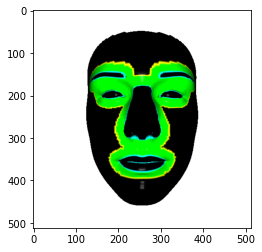

In [9]:
## un-comment and re-compute if you want to change the transition region
"""
transition_region = list(np.load('../BFM/trans_region_r0.1.npy'))

part_boundary_vertices = []
for key in part_vertices:
    if key != 'S_overall':
        part_boundary_vertices += find_boundary_vertices(get_tri_faces(part_vertices[key], Faces))
print(len(part_boundary_vertices))
transition_region += part_boundary_vertices


transition_region_ = []
transition_region_ += transition_region
for key in part_vertices:
    if key != 'S_overall':
        for idx in part_vertices[key]:
            if idx not in transition_region_:
                transition_region_.append(idx)             
temp_faces = get_tri_faces(transition_region_, Faces)
boundary_vertices = find_boundary_vertices(temp_faces)
for idx in part_boundary_vertices:
    if idx in boundary_vertices:
        boundary_vertices.remove(idx)


transition_region_faces = get_tri_faces(transition_region, Faces)


# save pre-computed results
#np.save('boundary_vertices.npy', np.array(boundary_vertices, dtype=np.int64))
#np.save('part_boundary_vertices.npy', np.array(part_boundary_vertices, dtype=np.int64))
#np.save('transition_region.npy', np.array(transition_region, dtype=np.int64))
#np.save('transition_region_faces.npy', transition_region_faces)
"""


# load pre-computed results
boundary_vertices = np.load('boundary_vertices.npy')
part_boundary_vertices = np.load('part_boundary_vertices.npy')
transition_region = np.load('transition_region.npy')
transition_region_faces = np.load('transition_region_faces.npy')



# visualize
T = np.zeros([35709,3], dtype=np.float32)
T[...] = 0
T[transition_region, 1] = 1.0
T[boundary_vertices, 0] = 1
T[part_boundary_vertices, 2] = 1
o3d_mesh_trans_region, image_trans_region = o3d_render(np.reshape(bfm['meanshape'], [35709,3]), T, Faces)
#o3d.visualization.draw_geometries([o3d_mesh_trans_region])
plt.imshow(image_trans_region)


In [10]:
def parsing2color(parsing):
    """
    Convert parsing label to color for visualization
    -----------------------------------------
    0: N/A         --- black   [0,0,0]
    1: face skin   --- green   [0,0,0]
    2: eye brows   --- red     [1,1,1]
    3: eyes        --- blue    [1,1,1]
    4: nose        --- yellow  [1,1,1]
    5: upper lip   --- purple  [1,1,1]
    6: lower lip   --- cyan    [1,1,1]
    """
    mapping = {
        0: np.array([.0,.0,.0]),
        1: np.array([.0,.0,.0]),
        2: np.array([.8,.8,.8]),
        3: np.array([1.0,1.0,1.0]),
        4: np.array([.3,.3,.3]),
        5: np.array([.8,.8,.8]),
        6: np.array([.4,.4,.4])
    }
    colors = np.zeros([parsing.shape[0], parsing.shape[1], 3])
    for i in range(parsing.shape[0]):
        for j in range(parsing.shape[1]):
            colors[i,j,:] = mapping[parsing[i,j]]
    return colors*255.

## We use this quick mapping tensor to convert the parsing label to r,g,b
mapping = torch.from_numpy(np.array([[.0,.0,.0], 
                                     [.0,.0,.0], 
                                     [.8,.8,.8], 
                                     [1.0,1.0,1.0], 
                                     [.3,.3,.3], 
                                     [.8,.8,.8], 
                                     [.4,.4,.4]], dtype=np.float32)*255.).to(device)
mapping.requires_grad = False



In [11]:
import math

# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=1):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding='same')

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

#gaussian_filter = get_gaussian_kernel(kernel_size=7, sigma=10, channels=1).to(device)
gaussian_filter = get_gaussian_kernel(kernel_size=20, sigma=2, channels=3).to(device)

def apply_gaussian_filter(gaussian_filter, x):
    ## x: [N,H,W,C]
    return gaussian_filter(x.permute(0,3,1,2)).permute(0,2,3,1)




In [12]:
def next_batch(idx, batch_size, img_path, parsing_path, shape_path, landmark_path, 
               coeff_path, img_indices, device):
    """
        returns: 
            images, 
            parsing_maps,
            facial_region_mask, 
            shapes, 
            {3dmm coefficients}, 
            new index
    """
    if idx + batch_size > len(img_indices):
        batch_size = len(img_indices) - idx
                
    batch_x = torch.zeros([batch_size, 3, 224, 224], dtype=torch.float32).to(device)
    batch_p = torch.zeros([batch_size, 224, 224, 3], dtype=torch.float32).to(device)
    batch_f = torch.zeros([batch_size, 224, 224], dtype=torch.float32).to(device)
    batch_s = torch.zeros([batch_size, 35709, 3], dtype=torch.float32).to(device)
    batch_lms = torch.zeros([batch_size, 68, 2], dtype=torch.float32).to(device)

    batch_id = torch.zeros([batch_size, 80], dtype=torch.float32).to(device)
    batch_tex = torch.zeros([batch_size, 80], dtype=torch.float32).to(device)
    batch_exp = torch.zeros([batch_size, 64], dtype=torch.float32).to(device)
    batch_rot = torch.zeros([batch_size, 3], dtype=torch.float32).to(device)
    batch_trans = torch.zeros([batch_size, 3], dtype=torch.float32).to(device)
    batch_gamma = torch.zeros([batch_size, 27], dtype=torch.float32).to(device)

    i = idx
    counter = 0
    while i < idx + batch_size:
        file_index = img_indices[i]
        
        img = Image.open(img_path.format(file_index))
        img = img.resize((224,224))
        img = np.asarray(img, dtype=np.float32)
        img = torch.from_numpy(img)
        img = img.permute(2,0,1)
        
        batch_x[counter] = img

        parsing_mask = np.load(parsing_path.format(file_index))
        parsing_mask_rgb = parsing2color(parsing_mask)
        batch_p[counter] = torch.from_numpy(parsing_mask_rgb)
        #batch_p[counter] = mapping[torch.from_numpy(parsing_mask)] # BUG
        
        batch_f[counter] = torch.from_numpy(np.where(parsing_mask > 1, 1.0, 0)) # mask of facial region

        batch_s[counter] = torch.from_numpy(np.reshape(np.load(shape_path.format(file_index)), [35709, 3]))

        batch_lms[counter] = torch.from_numpy(np.load(landmark_path.format(file_index), allow_pickle=True))

        id_ , tex_ , exp_ , rot_ , trans_, gamma_ = load_coefficients(coeff_path.format(file_index))
        batch_id[counter] = torch.from_numpy(id_)
        batch_tex[counter] = torch.from_numpy(tex_)
        batch_exp[counter] = torch.from_numpy(exp_)
        batch_rot[counter] = torch.from_numpy(rot_)
        batch_trans[counter] = torch.from_numpy(trans_)
        batch_gamma[counter] = torch.from_numpy(gamma_)
        
        
        i += 1
        counter += 1
        
    return batch_x, batch_p, batch_f, batch_s, batch_lms, batch_id, batch_tex, batch_exp, batch_rot, batch_trans, batch_gamma, i





In [13]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr.

    Returns:
        torch.Tensor: YCbCr version of the image.
    """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-1] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., :, :, 0]
    g: torch.Tensor = image[..., :, :, 1]
    b: torch.Tensor = image[..., :, :, 2]

    delta = .5
    y: torch.Tensor = .299 * r + .587 * g + .114 * b
    cb: torch.Tensor = (b - y) * .564 + delta
    cr: torch.Tensor = (r - y) * .713 + delta
    return torch.stack((y, cb, cr), -1)

label_index = {
    'S_rest': 1,
    'S_eyebrows': 2,
    'S_eyes': 3,
    'S_nose': 4,
    'S_ulip': 5,
    'S_llip': 6
}


In [14]:
def compute_photo_loss(pred_img, gt_img, img_mask, loss_type='l1'):
    """
    compute the mean l1 distance between input image and ground truth image 
    only face part is considered (ignore background and non-facial parts)
    """
    pred_img = pred_img.float()
    if loss_type == 'l1':
        loss = (torch.sum(torch.abs(pred_img - gt_img), 3) + 1e-8)*img_mask/255. # [N, H, W]    
    elif loss_type == 'l2':
        loss = torch.sqrt(torch.sum(torch.square(pred_img - gt_img), 3) + 1e-8)*img_mask/255. # [N, H, W]
    else:
        print('loss_type should be either l1 or l2')
        return None
    ##loss = torch.sum(loss, dim=(1, 2)) / torch.sum(img_mask, dim=(1, 2)) # will cause Nan!!
    loss = torch.mean(loss)
    return loss

def compute_parsing_loss(pred_mask, gt_mask):
    """
    compute the loss between rendered parsing masks and image parsing masks
    """
    loss = torch.square((pred_mask - gt_mask)) # [N, H, W]
    #loss = torch.sum(loss, dim=(1, 2)) / torch.sum(img_mask, dim=(1, 2))
    loss = torch.mean(loss)
    return loss

def compute_gamma_loss(gamma):
    gamma = gamma.reshape(-1, 3, 9) # why reshape 27 to 3x9 ?
    gamma_mean = torch.mean(gamma, dim=1, keepdims=True)
    gamma_loss = torch.mean(torch.square(gamma - gamma_mean))
    return gamma_loss


def compute_shape_loss(pred_shape, targ_shape):
    batch_size = pred_shape.shape[0]
    loss = torch.square(pred_shape - targ_shape)
    #loss = loss.sum(dim=[0, 1, 2]) / batch_size
    loss = torch.mean(loss)
    return loss


class mIoULoss(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(mIoULoss, self).__init__()

    def forward(self, inputs, target):
        inputs = inputs
        target = target # target are binary
        
        # inputs => N x H x W 
        # target_oneHot => N x H x W 
        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        #inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        inter_ = inputs * target
        
        ## Sum over all pixels N x H x W => N x 1
        inter = inter_.sum([1,2])

        # Denominator 
        union = inputs + target - (inter_)
        
        ## Sum over all pixels N x H x W => N x 1
        union = union.sum([1,2]) + 1e-8
        
        loss = 1 - inter/union
                
        ## Return average loss over classes and batch
        return loss.mean()

compute_iou_loss = mIoULoss()    


##compute_miou_loss(rendered_parsing[...,0], target_parsing[...,0])


def compute_lm_loss(pred_lms, gt_lms, img_size=224):
    """
    landmark loss
    """
    w = torch.ones((1, 68)).to(pred_lms.device)
    w[:, 17:27] = 0 # eye brows set to 0
    w[:, 27:31] = 10 # why set to 10?
    w[:, 48:68] = 10 # why set to 10?
    norm_w = w / w.sum()
    loss = torch.sum(torch.square(pred_lms/img_size - gt_lms/img_size), dim=2) * norm_w
    loss = torch.mean(loss.sum(1))

    return loss




In [15]:
"""Reload Weights"""
#####################
## Facenet
facenet.load_state_dict(torch.load('../saved_models/facenet'))
facenet.eval()

#####################
## Offset
offsetRegressor.load_state_dict(torch.load('../saved_models/offset_regressor'))
offsetRegressor.eval()

#####################
## Disentangle Nets (part encoders)
MODEL_PATH = '../saved_models/disentangle_nets/{}'
for key in latent_dims:
    disentangleNets[key].load_state_dict(torch.load(MODEL_PATH.format(key)))
    disentangleNets[key].eval()
    
#################
## Part Decoders
MODEL_PATH = '../saved_models/part_decoders/{}'
for key in part_vertices:
    part_decoders[key].load_state_dict(torch.load(MODEL_PATH.format(key)))
    part_decoders[key].eval()


## Parsing-Mask Guided Single Shape Adjusting

In [16]:
######################
## Load the mappings 
control_mappings = {
    'S_eyebrows': torch.from_numpy(np.load('../saved_models/mappings/S_eyebrows.npy')).to(device),
    'S_eyes': torch.from_numpy(np.load('../saved_models/mappings/S_eyes.npy')).to(device),
    'S_nose': torch.from_numpy(np.load('../saved_models/mappings/S_nose.npy')).to(device),
    'S_ulip': torch.from_numpy(np.load('../saved_models/mappings/S_ulip.npy')).to(device),
    'S_llip': torch.from_numpy(np.load('../saved_models/mappings/S_llip.npy')).to(device),
}
for key in control_mappings:
    print(key, ' :', int(control_mappings[key].shape[0]), ' controllers')

def mapping(M, f):
    # input (torch tensor):   measurement with size [1, f_dim]
    # output (torch tensor):  latent offset with size [1, z_dim]
    return f @ M



S_eyebrows  : 4  controllers
S_eyes  : 5  controllers
S_nose  : 6  controllers
S_ulip  : 4  controllers
S_llip  : 3  controllers


In [17]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

from arap_core.arap_utils import *

import torch
import torch.nn

class ARAP(torch.nn.Module):
    def __init__(self, pnts: torch.Tensor, tris: np.ndarray, handles, laplacian='cotangent', iA=None):
        """
            laplacian: 'cotangent' or 'combinatorial'
        """
        super().__init__()

        self.device = pnts.device

        anchors = list(handles.keys())
        self.handles = handles

        # number of points and anchors
        Np = len(pnts)
        Nc = len(anchors)

        if laplacian == 'cotangent':
            L = cotangent_laplacian(pnts=pnts, tris=tris)
        else:
            L = combinatorial_laplacian(pnts=pnts, tris=tris)

        # build the constraint matrix
        vals = np.ones(len(anchors))
        rows = np.arange(len(anchors))
        cols = np.array(anchors)
        C = scipy.sparse.csr_matrix( (vals, (rows, cols)), shape=(Nc, Np) )
                
        # cache everything that is needed
        self.L = L
        
        # form and invert the system
        if iA is None:
            A = scipy.sparse.bmat([
                [L.T@L, C.T],
                [C, szeros((Nc, Nc))]
            ]) # shape: [Np+Nc, Np+Nc]
            iA = np.linalg.pinv(A.toarray()).astype(np.float32)
        self.iA_ = iA

        # extract neighbors and weights, removing entries on the diagonal
        # these summed and negated should equal the diagonal for the Laplacian

        Lnbrs, Lwgts = matrix_indices_and_weights(L, zero_diag=False)
        Ldiag = -np.sum(Lwgts, axis=-1)

        self.P = pnts.shape[0]
        self.D = pnts.shape[1]
        self.C = len(anchors)
        self.anchors = anchors
        self.pnts = pnts#torch.nn.Parameter( pnts, requires_grad=False )
        self.Lnbrs = torch.nn.Parameter( torch.from_numpy(Lnbrs.astype(np.int64) ).to(self.device), requires_grad=False )
        self.Lwgts = torch.nn.Parameter( torch.from_numpy(Lwgts.astype(np.float32) ).to(self.device), requires_grad=False )
        self.Ldiag = torch.nn.Parameter( torch.from_numpy(Ldiag.astype(np.float32)).to(self.device), requires_grad=False )
        self.iA = torch.nn.Parameter( torch.from_numpy(iA).to(self.device), requires_grad=False )
        

    def _mul_L(self, pnts):
        return torch.sum( pnts[self.Lnbrs, :]*self.Lwgts[...,None], dim=1) + self.Ldiag[...,None]*pnts

    def _estimate_rhs(self, old_pnts, new_pnts):
        # get the neighborhoods
        O = -( old_pnts[self.Lnbrs, :] - old_pnts[:,None,:])*self.Lwgts[:,:,None]
        N = -( new_pnts[self.Lnbrs, :] - new_pnts[:,None,:])*self.Lwgts[:,:,None]
        
        # compute the rotation between the neighborhoods
        cov = N.permute(0,2,1) @ O
        U, s, Vt = torch.linalg.svd(cov.detach())

        # fix up the jacobian, if needed
        ones = torch.ones_like(s[:, 0], device=self.device)
        sign = torch.sign(torch.det(U @ Vt))
        s_new = torch.stack((ones,ones,sign), dim=-1)
        R = U @ (s_new[...,None]*Vt)

        # use average rotation for the edge to rotate the edge vectors
        d_new = torch.sum( ((R[self.Lnbrs, ...] + R[:,None,:,:]) @ O[..., None])[...,0]*(0.5*self.Lwgts[:,:,None]), dim=1 )
        return self._mul_L(d_new)

    def forward(self, num_iter=1):
        crhs = torch.stack([self.handles[a] for a in self.anchors], dim=0) # constraints
        lrhs = self._mul_L(self._mul_L(self.pnts))
        rhs = torch.cat([lrhs, crhs], dim=0)
        new_pnts = (self.iA @ rhs)[:self.P]
        
        for iter in range(num_iter):
            new_rhs = self._estimate_rhs(self.pnts, new_pnts)
            rhs = torch.cat([new_rhs, crhs], dim=0)
            new_pnts = (self.iA @ rhs)[:self.P]
        return new_pnts



In [37]:
torch.autograd.set_detect_anomaly(True)

forward_mapping = [i for i in range(len(transition_region))]
backward_mapping = np.copy(transition_region)
lookup = {transition_region[i] : i  for i in range(len(transition_region))}

handle_ids = [lookup[i] for i in boundary_vertices]

F = np.copy(transition_region_faces)
for i in range(len(F)):
    for j in range(len(F[i])):
        F[i, j] = lookup[F[i, j]]



# load a sample
idx = 0
batch_x, batch_p, batch_f, batch_s, batch_lms,\
batch_id, batch_tex, batch_exp,\
batch_rot, batch_trans, batch_gamma, idx = next_batch(idx, 1, img_path, parsing_path, 
                                                      shape_path, landmark_path, coeff_path, 
                                                      img_indices, device)
target_parsing = batch_p.detach()
target_parsing = apply_gaussian_filter(gaussian_filter, target_parsing)
batch_coeff = torch.cat([batch_id, batch_exp, batch_tex, batch_rot, batch_gamma, batch_trans], dim=1)



# parameters to adjust
parameters = []
offsets = torch.zeros((5, 2), dtype=torch.float32, requires_grad=True, device=device)
parameters.append(offsets)
controllers = {}
for key in control_mappings:
    dim = int(control_mappings[key].shape[0])
    controller = torch.zeros((1, dim), dtype=torch.float32, requires_grad=True, device=device)
    controllers[key] = controller
    parameters.append(controller)

optimizer = torch.optim.Adam(parameters, lr=1e-3)

# load the pre-computed inverse A will save time!
iA = np.load('iA.npy') 

for iter_ in range(15):

    # Clean gradient
    optimizer.zero_grad()

    # initialize part latents 
    shape_recon, _, _, pred_offsets = reconstruction(batch_x)
    part_mus = {}
    img_encodings = facenet(batch_x)
    for key in latent_dims:
        part_mu, part_sigma = disentangleNets[key](img_encodings)
        part_mus[key] = part_mu

    # construct
    preds = {}
    for key in latent_dims:
        if key == 'S_overall':
            continue
        part_mu = part_mus[key] + mapping(control_mappings[key], controllers[key])
        new_offsets = pred_offsets[0, offsetKeys[key], :] + offsets[offsetKeys[key], :]
        new_part_shape = part_decoders[key](part_mu)
        new_part_shape[0,:,1:] += new_offsets
        shape_recon[:,part_vertices[key],:] = new_part_shape

    shape_recon.retain_grad()

    # ARAP optimize
    pnts = shape_recon[0, backward_mapping]
    tensor_handles = {}
    for i in range(len(boundary_vertices)):
        vid = lookup[boundary_vertices[i]]
        vid_ = boundary_vertices[i]
        tensor_handles[vid] = shape_recon[0, vid_].detach()
    for i in range(len(boundary_vertices)):
        vid = lookup[part_boundary_vertices[i]]
        vid_ = part_boundary_vertices[i]
        tensor_handles[vid] = shape_recon[0, vid_].detach()
    torch_arap_solver = ARAP(pnts, F, tensor_handles, laplacian='combinatorial', iA=iA)
    iA = torch_arap_solver.iA_
    V_new_by_torch = torch_arap_solver(num_iter=2)


    shapes_ = torch.zeros([1, 35709, 3], dtype=torch.float32).to(device)
    shapes_[0] = shape_recon[0]
    shapes_[0, backward_mapping] = V_new_by_torch

    rendered_imgs, pred_lms, face_texture, mesh, rendered_parsing = bfm_model(batch_coeff, neutral_shape=shapes_, custom_texture=None)
    rendered_parsing = rendered_parsing[...,:3] #/ 255. # NHW
    rendered_parsing = apply_gaussian_filter(gaussian_filter, rendered_parsing)    

    face_mask_render = rendered_imgs[...,3].detach() > 0 # [N, H, W] 
    face_mask_img = batch_f.detach() > 0 # [N, H, W]
    face_mask = face_mask_render * face_mask_img

    ## Compute loss
    parsing_loss = compute_parsing_loss(rendered_parsing, target_parsing[...])
    loss = -parsing_loss
    print('loss ', -loss.data)

    ######
    ## BP
    loss.backward()
    
    ############
    ## Optimize
    optimizer.step()



loss  tensor(349.3950, device='cuda:0')
loss  tensor(340.8384, device='cuda:0')
loss  tensor(327.7852, device='cuda:0')
loss  tensor(322.5840, device='cuda:0')
loss  tensor(313.5420, device='cuda:0')
loss  tensor(304.8186, device='cuda:0')
loss  tensor(295.9249, device='cuda:0')
loss  tensor(289.2922, device='cuda:0')
loss  tensor(282.2803, device='cuda:0')
loss  tensor(270.4965, device='cuda:0')
loss  tensor(263.5017, device='cuda:0')
loss  tensor(252.4951, device='cuda:0')
loss  tensor(246.5895, device='cuda:0')
loss  tensor(240.2063, device='cuda:0')
loss  tensor(233.9126, device='cuda:0')


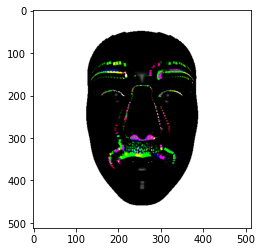

In [38]:
# visualize gradient
T = shape_recon.grad[0].detach().cpu().numpy()
o3d_mesh_gradient, gradient_img = o3d_render(np.reshape(bfm['meanshape'], [35709,3]), T, Faces)
#o3d.visualization.draw_geometries([o3d_mesh_gradient])
plt.imshow(gradient_img)



## Visualize result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


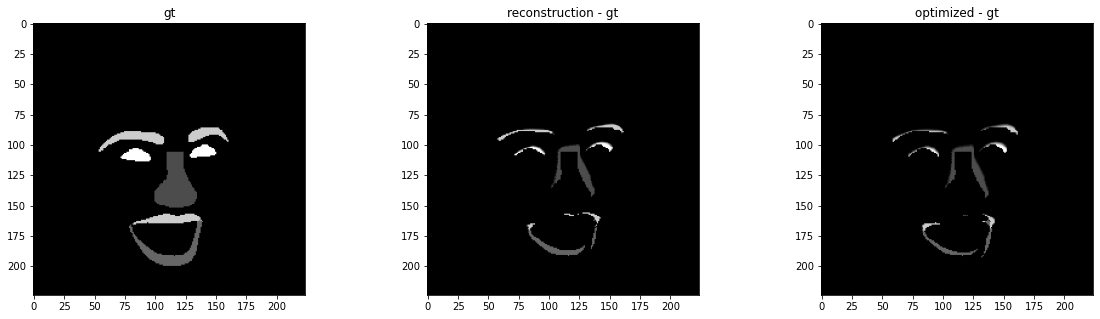

In [39]:
# initialize part latents 
original_shape, _, _, pred_offsets = reconstruction(batch_x)
part_mus = {}
kl_loss = 0
img_encodings = facenet(batch_x)
for key in latent_dims:
    part_mu, part_sigma = disentangleNets[key](img_encodings)
    part_mus[key] = part_mu
new_shape = torch.zeros([1, 35709, 3], dtype=torch.float32).to(device)
new_shape[0] = original_shape[0]

# construct
preds = {}
for key in latent_dims:
    if key == 'S_overall':
        continue
    part_mu = part_mus[key] + mapping(control_mappings[key], controllers[key])
    preds[key] = part_decoders[key](part_mu)
    new_offsets = pred_offsets[0, offsetKeys[key], :] + offsets[offsetKeys[key], :]
    preds[key][0,:,1:] += new_offsets
    new_shape[:,part_vertices[key],:] = preds[key]

# ARAP optimize
pnts = new_shape[0, backward_mapping]
tensor_handles = {}
for i in range(len(boundary_vertices)):
    vid = lookup[boundary_vertices[i]]
    vid_ = boundary_vertices[i]
    tensor_handles[vid] = new_shape[0, vid_].detach()
for i in range(len(boundary_vertices)):
    vid = lookup[part_boundary_vertices[i]]
    vid_ = part_boundary_vertices[i]
    tensor_handles[vid] = new_shape[0, vid_].detach()
torch_arap_solver = ARAP(pnts, F, tensor_handles, laplacian='combinatorial', iA=iA)
iA = torch_arap_solver.iA_
V_new_by_torch = torch_arap_solver(num_iter=2)
new_shape[0, backward_mapping] = V_new_by_torch
    
_, _, _, _, rendered_parsing_original = bfm_model(batch_coeff, neutral_shape=original_shape, custom_texture=None) 
_, _, _, _, rendered_parsing_new = bfm_model(batch_coeff, neutral_shape=new_shape, custom_texture=None) 


gt = batch_p[0].detach().cpu().numpy()/255.
im1 = rendered_parsing_original[0,...,:3].detach().cpu().numpy()/255.
im2 = rendered_parsing_new[0,...,:3].detach().cpu().numpy()/255.
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('gt')
plt.imshow(gt)
plt.subplot(1,3,2)
plt.title('reconstruction - gt')
plt.imshow(im1 - gt)
plt.subplot(1,3,3)
plt.title('optimized - gt')
plt.imshow(im2 - gt)
plt.show()
